##**Environment Setup & Imports**

In [1]:
import os
import re
import json
import pickle
import random
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Computer Vision
from PIL import Image
from torchvision import transforms, models

# NLTK for BLEU
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using device: cuda
PyTorch version: 2.8.0+cu126


##**Locate Dataset Files**

In [2]:
def find_image_dir():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
CAPTIONS_PATH = None

for root, dirs, files in os.walk('/kaggle/input'):
    if 'captions.txt' in files:
        CAPTIONS_PATH = os.path.join(root, 'captions.txt')
        break

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find Flickr30k image directory")

if CAPTIONS_PATH:
    print(f"Found captions at: {CAPTIONS_PATH}")
else:
    raise FileNotFoundError("Could not find captions.txt")

FEATURES_FILE = '/kaggle/working/flickr30k_features.pkl'
print(f"Features will be saved to: {FEATURES_FILE}")

Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
Found captions at: /kaggle/input/datasets/adityajn105/flickr30k/captions.txt
Features will be saved to: /kaggle/working/flickr30k_features.pkl


##**Feature Extraction with ResNet50**

In [3]:
if not os.path.exists(FEATURES_FILE):
    print("\n[FEATURE EXTRACTION] Extracting ResNet50 features...")

    class FlickrDataset(Dataset):
        def __init__(self, img_dir, transform):
            self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
            self.transform = transform
            self.img_dir = img_dir

        def __len__(self):
            return len(self.img_names)

        def __getitem__(self, idx):
            name = self.img_names[idx]
            img_path = os.path.join(self.img_dir, name)
            img = Image.open(img_path).convert('RGB')
            return self.transform(img), name


    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model = nn.Sequential(*list(model.children())[:-1])
    model = nn.DataParallel(model).to(device)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])


    dataset = FlickrDataset(IMAGE_DIR, transform)
    loader = DataLoader(dataset, batch_size=128, num_workers=4, shuffle=False)


    features_dict = {}
    with torch.no_grad():
        for imgs, names in tqdm(loader, desc="Extracting Features"):
            feats = model(imgs.to(device)).view(imgs.size(0), -1)
            for i, name in enumerate(names):
                features_dict[name] = feats[i].cpu().numpy()


    with open(FEATURES_FILE, 'wb') as f:
        pickle.dump(features_dict, f)
    print(f"\nSuccess! {len(features_dict)} images processed and saved to {FEATURES_FILE}")
else:
    print(f"\nFeatures file already exists. Skipping extraction.")


[FEATURE EXTRACTION] Extracting ResNet50 features...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s] 
Extracting Features: 100%|██████████| 249/249 [01:48<00:00,  2.29it/s]



Success! 31783 images processed and saved to /kaggle/working/flickr30k_features.pkl


##**Caption Preprocessing & Vocabulary**

In [4]:
print("\n[CAPTION PREPROCESSING] Loading and cleaning captions...")

# Load captions using proper CSV parsing with quote handling
df = pd.read_csv(
    CAPTIONS_PATH,
    sep=',',
    quotechar='"',
    skipinitialspace=True,  # Skip spaces after commas
    engine='python',        # More robust for complex quoting
    on_bad_lines='skip'     # Skip any malformed lines (Kaggle pandas version)
)

# Clean column names (remove extra spaces)
df.columns = df.columns.str.strip()

# Handle column naming variations
if 'image' in df.columns and 'caption' in df.columns:
    df = df.rename(columns={'image': 'image_name', 'caption': 'caption'})
elif df.shape[1] >= 2:
    # Fallback: assume first column is image filename, second is caption
    df.columns = ['image_name', 'caption'] + [f'extra_{i}' for i in range(df.shape[1]-2)]
    if 'extra_0' in df.columns:
        # Merge extra columns back into caption (happens if unquoted commas exist)
        df['caption'] = df['caption'].astype(str) + ' ' + df[[c for c in df.columns if c.startswith('extra_')]].fillna('').astype(str).agg(' '.join, axis=1)
else:
    raise ValueError(f"Unexpected CSV structure with {df.shape[1]} columns")

# Keep only needed columns
df = df[['image_name', 'caption']].copy()

# Clean whitespace and remove empty captions
df['image_name'] = df['image_name'].astype(str).str.strip()
df['caption'] = df['caption'].astype(str).str.strip()
df = df[df['caption'] != ''].reset_index(drop=True)

def clean_caption(caption):
    caption = str(caption).lower()
    caption = re.sub(r"[^a-z0-9\s]", "", caption)  # Keep only alphanumeric + spaces
    caption = re.sub(r"\s+", " ", caption).strip()
    return caption

df['caption'] = df['caption'].apply(clean_caption)

# Group captions by image
image_captions = df.groupby('image_name')['caption'].apply(list).to_dict()
print(f"Loaded {len(df)} captions for {len(image_captions)} images")
print(f"Sample captions for {list(image_captions.keys())[0]}:")
for i, cap in enumerate(image_captions[list(image_captions.keys())[0]][:3], 1):
    print(f"    {i}. {cap}")

# Build vocabulary
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.freqs = Counter()

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, captions_list):
        for captions in captions_list:
            for caption in captions:
                self.freqs.update(caption.split())

        idx = 4
        for word, freq in self.freqs.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokens = text.split()
        return [
            self.stoi.get(token, self.stoi["<unk>"])
            for token in tokens
        ]

# Create vocabulary
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(list(image_captions.values()))
print(f"\nVocabulary size: {len(vocab)}")
print(f"Top 10 words by frequency: {vocab.freqs.most_common(10)}")

# Tokenize captions with special tokens
tokenized_captions = {}
for img_name, captions in image_captions.items():
    tokenized_captions[img_name] = []
    for caption in captions:
        tokens = [vocab.stoi["<start>"]] + vocab.numericalize(caption) + [vocab.stoi["<end>"]]
        tokenized_captions[img_name].append(tokens)

# Train/val/test split (80/10/10)
all_images = list(image_captions.keys())
random.shuffle(all_images)
n = len(all_images)
train_split = int(0.8 * n)
val_split = int(0.9 * n)

train_imgs = all_images[:train_split]
val_imgs = all_images[train_split:val_split]
test_imgs = all_images[val_split:]

print(f"\nDataset split:")
print(f"   Train: {len(train_imgs):,} images")
print(f"   Val:   {len(val_imgs):,} images")
print(f"   Test:  {len(test_imgs):,} images")
print(f"\nExpected: 31,783 total images (5 captions each = 158,915 total captions)")
print(f"Actual:   {len(image_captions):,} images ({len(df):,} captions)")


[CAPTION PREPROCESSING] Loading and cleaning captions...
Loaded 158915 captions for 31783 images
Sample captions for 1000092795.jpg:
    1. two young guys with shaggy hair look at their hands while hanging out in the yard
    2. two young white males are outside near many bushes
    3. two men in green shirts are standing in a yard

Vocabulary size: 7727
Top 10 words by frequency: [('a', 271704), ('in', 83466), ('the', 62978), ('on', 45669), ('and', 44263), ('man', 42598), ('is', 41117), ('of', 38776), ('with', 36207), ('woman', 22211)]

Dataset split:
   Train: 25,426 images
   Val:   3,178 images
   Test:  3,179 images

Expected: 31,783 total images (5 captions each = 158,915 total captions)
Actual:   31,783 images (158,915 captions)


##**PyTorch Dataset & DataLoader**

In [5]:
class CaptionDataset(Dataset):
    def __init__(self, img_names, features_dict, tokenized_captions, vocab):
        self.img_names = img_names
        self.features_dict = features_dict
        self.tokenized_captions = tokenized_captions
        self.vocab = vocab

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        features = torch.tensor(self.features_dict[img_name], dtype=torch.float32)
        caption = random.choice(self.tokenized_captions[img_name])  # Random caption during training
        caption = torch.tensor(caption, dtype=torch.long)
        return features, caption, img_name

def collate_fn(batch):
    features, captions, img_names = zip(*batch)
    features = torch.stack(features)
    captions_padded = pad_sequence(captions, batch_first=True, padding_value=vocab.stoi["<pad>"])
    return features, captions_padded, img_names

# Load features
with open(FEATURES_FILE, 'rb') as f:
    features_dict = pickle.load(f)

# Create datasets
BATCH_SIZE = 64
train_dataset = CaptionDataset(train_imgs, features_dict, tokenized_captions, vocab)
val_dataset = CaptionDataset(val_imgs, features_dict, tokenized_captions, vocab)
test_dataset = CaptionDataset(test_imgs, features_dict, tokenized_captions, vocab)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=collate_fn, num_workers=2)

print(f"\nDataloaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")


Dataloaders created:
   Train batches: 398
   Val batches:   50
   Test batches:  50


##**Seq2Seq Model Architecture**

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size=2048, hidden_size=512):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()

    def forward(self, features):
        return self.relu(self.linear(features))  # (batch_size, hidden_size)

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions[:, :-1])  # Teacher forcing: exclude last token
        h0 = features.unsqueeze(0)  # (1, batch_size, hidden_size)
        c0 = torch.zeros_like(h0)
        lstm_out, _ = self.lstm(embeddings, (h0, c0))
        return self.linear(lstm_out)  # (batch_size, seq_len-1, vocab_size)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, features, captions):
        encoder_outputs = self.encoder(features)
        return self.decoder(encoder_outputs, captions)

# Initialize model
HIDDEN_SIZE = 512
EMBED_SIZE = 256
VOCAB_SIZE = len(vocab)

encoder = Encoder(input_size=2048, hidden_size=HIDDEN_SIZE)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE,
                  vocab_size=VOCAB_SIZE, num_layers=1)
model = Seq2Seq(encoder, decoder).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Seq2Seq(
  (encoder): Encoder(
    (linear): Linear(in_features=2048, out_features=512, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (embedding): Embedding(7727, 256)
    (lstm): LSTM(256, 512, batch_first=True)
    (linear): Linear(in_features=512, out_features=7727, bias=True)
  )
)

Total parameters: 8,568,111
Trainable parameters: 8,568,111


##**Training Loop with Validation & Best Model Saving**

In [7]:
# Training configuration
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 15
PATIENCE = 3

# Tracking metrics
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
best_model_path = '/kaggle/working/best_model.pth'

print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

for epoch in range(NUM_EPOCHS):
    # TRAINING PHASE
    model.train()
    total_train_loss = 0

    for features, captions, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        features = features.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        outputs = model(features, captions)

        # Reshape for loss computation
        outputs = outputs.reshape(-1, VOCAB_SIZE)
        targets = captions[:, 1:].reshape(-1)  # Skip <start> token

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # VALIDATION PHASE
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for features, captions, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            features = features.to(device)
            captions = captions.to(device)

            outputs = model(features, captions)
            outputs = outputs.reshape(-1, VOCAB_SIZE)
            targets = captions[:, 1:].reshape(-1)

            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # EPOCH SUMMARY
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")

    # SAVE BEST MODEL
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'vocab': vocab
        }, best_model_path)
        print(f" New best model saved (val_loss={best_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f" No improvement for {patience_counter} epoch(s)")

    # EARLY STOPPING
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)


STARTING TRAINING


Epoch 1/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 89.13it/s] 



Epoch 1/15
  Train Loss: 4.4653
  Val Loss:   3.9401
 New best model saved (val_loss=3.9401)


Epoch 2/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.16it/s] 



Epoch 2/15
  Train Loss: 3.7555
  Val Loss:   3.6464
 New best model saved (val_loss=3.6464)


Epoch 3/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 92.74it/s] 



Epoch 3/15
  Train Loss: 3.4859
  Val Loss:   3.4809
 New best model saved (val_loss=3.4809)


Epoch 4/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 88.62it/s] 



Epoch 4/15
  Train Loss: 3.3139
  Val Loss:   3.3482
 New best model saved (val_loss=3.3482)


Epoch 5/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.71it/s] 



Epoch 5/15
  Train Loss: 3.1878
  Val Loss:   3.2357
 New best model saved (val_loss=3.2357)


Epoch 6/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 89.33it/s] 



Epoch 6/15
  Train Loss: 3.0956
  Val Loss:   3.2043
 New best model saved (val_loss=3.2043)


Epoch 7/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.77it/s] 



Epoch 7/15
  Train Loss: 3.0024
  Val Loss:   3.1467
 New best model saved (val_loss=3.1467)


Epoch 8/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 88.45it/s] 



Epoch 8/15
  Train Loss: 2.9352
  Val Loss:   3.1226
 New best model saved (val_loss=3.1226)


Epoch 9/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 87.42it/s]



Epoch 9/15
  Train Loss: 2.8692
  Val Loss:   3.0874
 New best model saved (val_loss=3.0874)


Epoch 10/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 88.38it/s] 



Epoch 10/15
  Train Loss: 2.8038
  Val Loss:   3.0755
 New best model saved (val_loss=3.0755)


Epoch 11/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 87.76it/s] 



Epoch 11/15
  Train Loss: 2.7566
  Val Loss:   3.0709
 New best model saved (val_loss=3.0709)


Epoch 12/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 83.81it/s]



Epoch 12/15
  Train Loss: 2.7136
  Val Loss:   3.0555
 New best model saved (val_loss=3.0555)


Epoch 13/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 86.11it/s]



Epoch 13/15
  Train Loss: 2.6468
  Val Loss:   3.0662
 No improvement for 1 epoch(s)


Epoch 14/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.29it/s] 



Epoch 14/15
  Train Loss: 2.6090
  Val Loss:   3.0386
 New best model saved (val_loss=3.0386)


Epoch 15/15 [Val]: 100%|██████████| 50/50 [00:00<00:00, 88.06it/s] 



Epoch 15/15
  Train Loss: 2.5672
  Val Loss:   3.0251
 New best model saved (val_loss=3.0251)

TRAINING COMPLETE


##**Loss Curve Visualization**

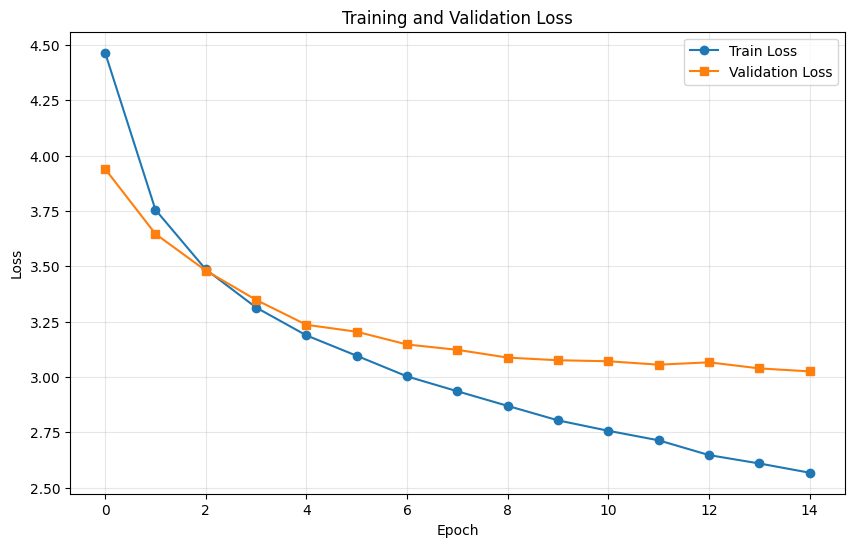

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/kaggle/working/loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()


##**Inference Functions (Greedy & Beam Search)**

In [12]:
def greedy_search(model, features, max_len=20):
    """Fixed greedy search with proper state management"""
    model.eval()
    with torch.no_grad():
        encoder_out = model.encoder(features.unsqueeze(0))  # (1, hidden_size)

        current_token = torch.tensor([vocab.stoi["<start>"]], device=device)
        caption_tokens = [current_token.item()]

        hidden = encoder_out.unsqueeze(0)  # (1, 1, hidden_size)
        cell = torch.zeros_like(hidden)

        for _ in range(max_len):
            word_embed = model.decoder.embedding(current_token.unsqueeze(0))
            lstm_out, (hidden, cell) = model.decoder.lstm(word_embed, (hidden, cell))
            output = model.decoder.linear(lstm_out.squeeze(0))
            current_token = output.argmax(1)

            token_id = current_token.item()
            caption_tokens.append(token_id)

            if token_id == vocab.stoi["<end>"] or token_id == vocab.stoi["<pad>"]:
                break

        # Convert to words
        words = []
        for token_id in caption_tokens[1:]:
            if token_id in [vocab.stoi["<end>"], vocab.stoi["<pad>"]]:
                break
            words.append(vocab.itos.get(token_id, "<unk>"))

        return ' '.join(words)

def beam_search_fixed(model, features, beam_width=3, max_len=20):
    """
    CORRECT beam search with proper state cloning per beam candidate.
    Fixes repetitive output bug caused by shared LSTM states.
    """
    model.eval()
    with torch.no_grad():
        # Encode image features → hidden state
        encoder_out = model.encoder(features.unsqueeze(0))  # (1, hidden_size)

        # Beam candidates: each is (sequence, cumulative_log_prob, hidden, cell)
        # Initialize with <start> token
        beams = [(
            [vocab.stoi["<start>"]],
            0.0,
            encoder_out.unsqueeze(0).clone(),  # (1, 1, hidden_size) - MUST clone
            torch.zeros_like(encoder_out.unsqueeze(0)).clone()  # (1, 1, hidden_size)
        )]
        completed_beams = []

        for step in range(max_len):
            candidates = []

            for seq, log_prob, hidden, cell in beams:
                last_token = seq[-1]

                # If beam ended, move to completed
                if last_token == vocab.stoi["<end>"] or last_token == vocab.stoi["<pad>"]:
                    completed_beams.append((seq, log_prob))
                    continue

                # Embed last token
                token_tensor = torch.tensor([last_token], device=device)
                embed = model.decoder.embedding(token_tensor).unsqueeze(0)  # (1, 1, embed_size)

                # LSTM step WITH beam-specific states
                lstm_out, (new_hidden, new_cell) = model.decoder.lstm(embed, (hidden, cell))

                # Predict next token distribution
                logits = model.decoder.linear(lstm_out.squeeze(0))  # (1, vocab_size)
                log_probs = torch.log_softmax(logits, dim=1).squeeze(0)  # (vocab_size,)

                # Get top-k next tokens
                topk_log_probs, topk_indices = log_probs.topk(beam_width)

                for i in range(beam_width):
                    token_id = topk_indices[i].item()
                    token_log_prob = topk_log_probs[i].item()

                    # Build new sequence
                    new_seq = seq + [token_id]
                    new_log_prob = log_prob + token_log_prob
                    candidates.append((
                        new_seq,
                        new_log_prob,
                        new_hidden.clone(),
                        new_cell.clone()
                    ))

            # Sort candidates by log probability and select top-k
            candidates.sort(key=lambda x: x[1], reverse=True)
            beams = candidates[:beam_width]

        # Add remaining beams to completed
        for seq, log_prob, _, _ in beams:
            if seq[-1] != vocab.stoi["<end>"]:
                seq.append(vocab.stoi["<end>"])
            completed_beams.append((seq, log_prob))

        # Select best beam (highest log probability)
        if not completed_beams:
            return "a picture"

        best_seq = max(completed_beams, key=lambda x: x[1])[0]

        # Convert to words (skip <start>, stop at <end>)
        words = []
        for token_id in best_seq[1:]:
            if token_id == vocab.stoi["<end>"] or token_id == vocab.stoi["<pad>"]:
                break
            words.append(vocab.itos.get(token_id, "<unk>"))

        caption = ' '.join(words)
        return caption if caption.strip() else "a picture"

print("Testing inference functions on sample image...")
test_img = test_imgs[0]
test_feat = torch.tensor(features_dict[test_img], dtype=torch.float32).to(device)

greedy_cap = greedy_search(model, test_feat)
beam_cap = beam_search_fixed(model, test_feat, beam_width=3)

print(f"Image: {test_img}")
print(f"Ground truth: {image_captions[test_img][0]}")
print(f"Greedy:       '{greedy_cap}'")
print(f"Beam (k=3):   '{beam_cap}'")


Testing inference functions on sample image...
Image: 4963789758.jpg
Ground truth: an older woman is featured in the fore ground of a large race that a number of people are running in
Greedy:       'a man in a blue shirt and shorts is running in a race'
Beam (k=3):   'a man in a white shirt and shorts is running in a race'


**Evaluation Functions Cell**

In [17]:
# ================= BLEU + TOKEN METRICS =================

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import numpy as np


# ---------------- BLEU-4 ----------------
def calculate_bleu4(predictions, references):
    """
    predictions: list of generated captions (strings)
    references: list of list of ground truth captions
    """
    
    smoothie = SmoothingFunction().method4
    
    # Tokenize predictions
    preds_tok = [pred.split() for pred in predictions]
    
    # Tokenize references properly
    refs_tok = []
    for refs in references:
        if isinstance(refs, list):
            refs_tok.append([ref.split() for ref in refs])
        else:
            refs_tok.append([refs.split()])
    
    bleu4 = corpus_bleu(
        refs_tok,
        preds_tok,
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=smoothie
    )
    
    return bleu4


# ---------------- TOKEN METRICS ----------------
def calculate_token_metrics(predictions, references):
    
    precisions = []
    recalls = []
    f1s = []
    
    for pred, refs in zip(predictions, references):
        
        # Lowercase normalization
        pred_tokens = set(pred.lower().split())
        
        if isinstance(refs, list):
            ref_tokens = set(" ".join(refs).lower().split())
        else:
            ref_tokens = set(refs.lower().split())
        
        tp = len(pred_tokens & ref_tokens)
        
        precision = tp / len(pred_tokens) if pred_tokens else 0
        recall = tp / len(ref_tokens) if ref_tokens else 0
        
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    
    # FINAL RETURN 
    return (
        np.mean(precisions),
        np.mean(recalls),
        np.mean(f1s)
    )


##**Evaluation Metrics (BLEU-4, Precision, Recall, F1)**

In [18]:
# ===================== EVALUATION CELL =====================

model.eval()

test_predictions_greedy = []
test_predictions_beam = []
test_references = []

with torch.no_grad():
    
    for features, captions, img_names in tqdm(test_loader, desc="Generating captions"):
        
        features = features.to(device)
        
        for j in range(len(img_names)):
            
            feat = features[j]
            
            # ----- Generate captions -----
            greedy_cap = greedy_search(model, feat)
            beam_cap   = beam_search_fixed(model, feat, beam_width=3)
            
            test_predictions_greedy.append(greedy_cap)
            test_predictions_beam.append(beam_cap)
            
            # ----- References -----
            refs = image_captions[img_names[j]]
            
            if isinstance(refs, str):
                refs = [refs]
            
            test_references.append(refs)


# ===================== METRICS =====================

bleu_greedy = calculate_bleu4(
    test_predictions_greedy,
    test_references
)

bleu_beam = calculate_bleu4(
    test_predictions_beam,
    test_references
)

prec_g, rec_g, f1_g = calculate_token_metrics(
    test_predictions_greedy,
    test_references
)

prec_b, rec_b, f1_b = calculate_token_metrics(
    test_predictions_beam,
    test_references
)


# ===================== PRINT RESULTS =====================

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)

print(f"\nGreedy Search:")
print(f"  BLEU-4:    {bleu_greedy:.4f}")
print(f"  Precision: {prec_g:.4f}")
print(f"  Recall:    {rec_g:.4f}")
print(f"  F1-Score:  {f1_g:.4f}")

print(f"\nBeam Search (k=3):")
print(f"  BLEU-4:    {bleu_beam:.4f}")
print(f"  Precision: {prec_b:.4f}")
print(f"  Recall:    {rec_b:.4f}")
print(f"  F1-Score:  {f1_b:.4f}")


# ===================== COMPARISON =====================

if bleu_beam > bleu_greedy:
    
    improvement = (
        (bleu_beam - bleu_greedy) /
        max(bleu_greedy, 1e-8)
    ) * 100
    
    print(f"\nSUCCESS: Beam search outperforms greedy by {improvement:.1f}%")

else:
    
    print(f"\nBeam search BLEU ({bleu_beam:.4f}) <= greedy ({bleu_greedy:.4f})")
    print("Showing 5 sample beam outputs:")
    
    for i in range(min(5, len(test_predictions_beam))):
        print(f"{i+1}. '{test_predictions_beam[i]}'")


# ===================== SAVE RESULTS =====================

import json

results_fixed = {
    "greedy": {
        "bleu4": float(bleu_greedy),
        "precision": float(prec_g),
        "recall": float(rec_g),
        "f1": float(f1_g)
    },
    "beam_k3_fixed": {
        "bleu4": float(bleu_beam),
        "precision": float(prec_b),
        "recall": float(rec_b),
        "f1": float(f1_b)
    }
}

with open("/kaggle/working/evaluation_fixed.json", "w") as f:
    json.dump(results_fixed, f, indent=4)

print("\nResults saved to /kaggle/working/evaluation_fixed.json")


Generating captions: 100%|██████████| 50/50 [01:55<00:00,  2.30s/it]



EVALUATION RESULTS

Greedy Search:
  BLEU-4:    0.1682
  Precision: 0.5697
  Recall:    0.1658
  F1-Score:  0.2522

Beam Search (k=3):
  BLEU-4:    0.1859
  Precision: 0.5950
  Recall:    0.1630
  F1-Score:  0.2515

SUCCESS: Beam search outperforms greedy by 10.6%

Results saved to /kaggle/working/evaluation_fixed.json


##**Display Sample Caption Examples**

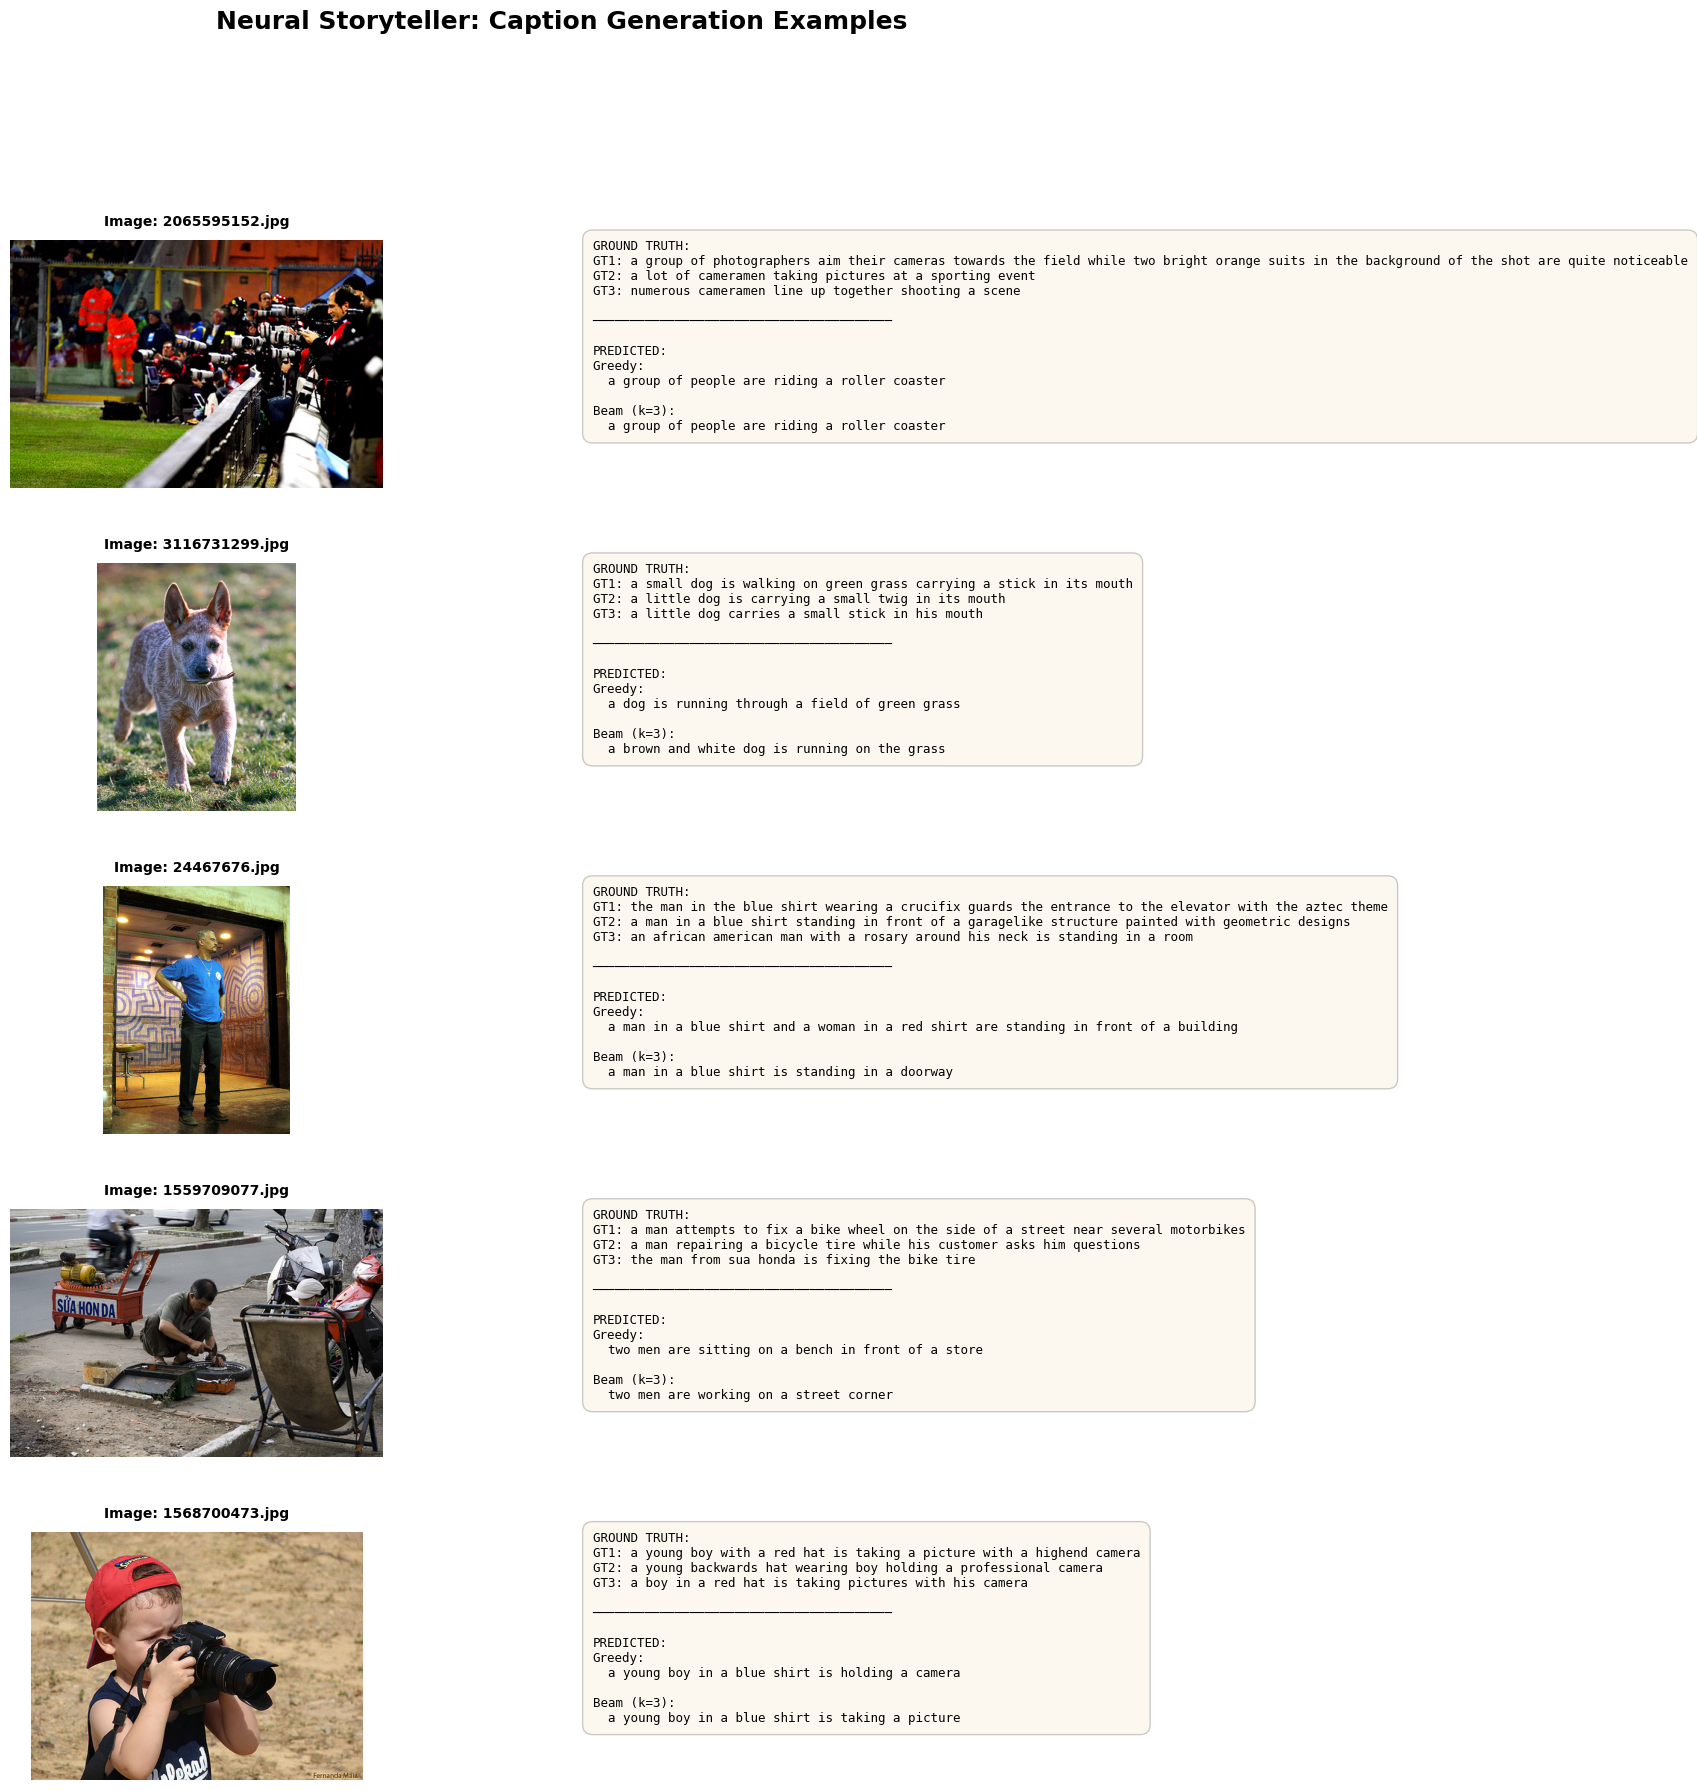

In [20]:
model.eval()
# Select 5 diverse test images
sample_images = random.sample(test_imgs, 5)

fig = plt.figure(figsize=(16, 20))
gs = fig.add_gridspec(5, 2, width_ratios=[1, 1.3], hspace=0.3, wspace=0.3)

for idx, img_name in enumerate(sample_images):
    # Load image
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = Image.open(img_path).convert('RGB')

    # Generate captions using current model
    feat = torch.tensor(features_dict[img_name], dtype=torch.float32).to(device)
    greedy_cap = greedy_search(model, feat)
    beam_cap = beam_search_fixed(model, feat, beam_width=3)
    gt_captions = image_captions[img_name]

    # Image subplot
    ax_img = fig.add_subplot(gs[idx, 0])
    ax_img.imshow(img)
    ax_img.axis('off')
    ax_img.set_title(f"Image: {img_name}", fontsize=10, fontweight='bold', pad=10)

    # Captions subplot
    ax_txt = fig.add_subplot(gs[idx, 1])
    ax_txt.axis('off')

    gt_text = "\n".join([f"GT{i+1}: {cap}" for i, cap in enumerate(gt_captions[:3])])
    pred_text = f"Greedy:\n  {greedy_cap}\n\nBeam (k=3):\n  {beam_cap}"

    full_text = f"GROUND TRUTH:\n{gt_text}\n\n{'─'*40}\n\nPREDICTED:\n{pred_text}"
    ax_txt.text(0, 1, full_text, transform=ax_txt.transAxes,
                fontsize=9, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2, pad=0.8))

plt.suptitle('Neural Storyteller: Caption Generation Examples',
             fontsize=18, fontweight='bold', y=0.995)
plt.savefig('/kaggle/working/sample_captions.png', dpi=300, bbox_inches='tight')
plt.show()
